**Import libraries**

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)



**Load dataset**

In [52]:
df = pd.read_csv("UniversalBank.csv")
cols_to_drop = [c for c in ['ID','Id','Zip Code','ZIP Code','ZIP','zip','Zip'] if c in df.columns]
df = df.drop(columns=cols_to_drop)
if 'PersonalLoan' in df.columns and 'Personal Loan' not in df.columns:
    df = df.rename(columns={'PersonalLoan':'Personal Loan'})

**Data Summary**

In [54]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal Loan       5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


**Question 1 – Partition the data (75% training, 25% validation)**

In [63]:
X = df.drop(columns=['Personal Loan'])
y = df['Personal Loan']

if 'Education' in X.columns:
    X = pd.get_dummies(X, columns=['Education'], prefix='Education', drop_first=False)
if 'CreditCard' in X.columns:
    X = X.rename(columns={'CreditCard': 'CreditCard'})

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.75, random_state=RANDOM_SEED, stratify=y)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("\nThis output indicates that we have managed to split the data into training (3750, 13) and validation (1250, 13) sets, " \
"\nrespectively, using 75% for training and 25% for validation.")

Training set shape: (3750, 13)
Validation set shape: (1250, 13)

This output indicates that we have managed to split the data into training (3750, 13) and validation (1250, 13) sets, 
respectively, using 75% for training and 25% for validation.


**Question 2 – Define the given customer**

In [64]:
cust = {
    'Age':40,'Experience':10,'Income':84,'Family':2,'CCAvg':2,
    'Education_1':0,'Education_2':1,'Education_3':0,
    'Mortgage':0,'Securities Account':1,'CD Account':1,'Online':1,'CreditCard':1}

customer_row = pd.Series(0.0, index=X_train.columns)
for k,v in cust.items():
    if k in customer_row.index:
        customer_row[k] = v
    else:
        variants = {
            'Securities Account':['Securities Account','SecuritiesAccount','Securities_Account'],
            'CD Account':['CD Account','CDAccount','CD_Account'],
            'CreditCard':['CreditCard','Credit Card','Credit_Card'],
            'CCAvg':['CCAvg','CC Avg','CC_Avg']}
        if k in variants:
            for alt in variants[k]:
                if alt in customer_row.index:
                    customer_row[alt] = v
                    break
display(customer_row.to_frame().T)

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40.0,10.0,84.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


**Question 3 – Standardize data using training mean & std**

In [71]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_val_s   = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
customer_std = scaler.transform([customer_row.values])[0]

print("Training mean (first 5 features):\n", scaler.mean_[:5])
print("Training std (first 5 features):\n", scaler.scale_[:5])
print("\nThe StandardScaler was used to standardize the training and validation sets, besides the customer data, " \
"\nby subtracting the mean and scaling to unit variance for consistency across all datasets.")

Training mean (first 5 features):
 [45.34346667 20.10986667 73.7872      2.38986667  1.95087467]
Training std (first 5 features):
 [11.3985919  11.39947057 46.53769851  1.14589295  1.76819618]

The StandardScaler was used to standardize the training and validation sets, besides the customer data, 
by subtracting the mean and scaling to unit variance for consistency across all datasets.


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Question 4 – k-NN classification (k = 1)**

In [70]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_s, y_train)
cust_pred_k1 = int(knn1.predict([customer_std])[0])

print("Q4: Customer classification using k=1 →", cust_pred_k1)
print("\nCustomer's Prediction: The customer was classified as 0, meaning the model predicts they will not accept the loan."
"\nPreprocessing involved standardizing the data, using all relevant features (except ID and ZIP Code), and training a k-NN model with k=1."
"\nThe model used the closest neighbor in the training data to make this prediction. " \
"\nSince the closest neighbor was classified as 0, the model predicts this customer will not accept the loan.")


Q4: Customer classification using k=1 → 0

Customer's Prediction: The customer was classified as 0, meaning the model predicts they will not accept the loan.
Preprocessing involved standardizing the data, using all relevant features (except ID and ZIP Code), and training a k-NN model with k=1.
The model used the closest neighbor in the training data to make this prediction. 
Since the closest neighbor was classified as 0, the model predicts this customer will not accept the loan.


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


**Question 5 – Find optimal k using validation**

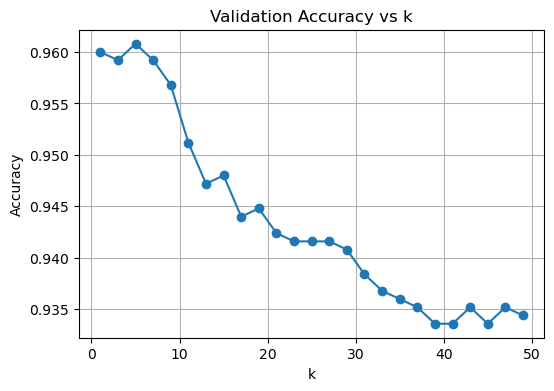

Q5: Optimal k = 5

Graphically, the best value for k is 5 because it actually reaches a balance between overfitting and underfitting.
For the values of k less than that, the model becomes overly sensitive to noise in the data; for values of k larger than that, 
it becomes too simplistic and fails to capture important patterns in the data. 
k=5 provides the topmost accuracy on the validation set, ensuring the model is adequately complex to learn from the patterns 
in the data while being simple enough to generalize well to new data.


In [72]:
ks = [k for k in range(1, 50, 2)]
val_acc = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    val_acc.append(accuracy_score(y_val, knn.predict(X_val_s)))

best_k = ks[np.argmax(val_acc)]

plt.figure(figsize=(6,4))
plt.plot(ks, val_acc, marker='o')
plt.title("Validation Accuracy vs k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print("Q5: Optimal k =", best_k)
print("\nGraphically, the best value for k is 5 because it actually reaches a balance between overfitting and underfitting." \
"\nFor the values of k less than that, the model becomes overly sensitive to noise in the data; for values of k larger than that, " \
"\nit becomes too simplistic and fails to capture important patterns in the data. " \
"\nk=5 provides the topmost accuracy on the validation set, ensuring the model is adequately complex to learn from the patterns "
"\nin the data while being simple enough to generalize well to new data.")

**Question 6 – Confusion matrix (validation, optimal k)**

In [76]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_s, y_train)
y_val_pred = knn_best.predict(X_val_s)

cm_val = confusion_matrix(y_val, y_val_pred)

print("Confusion Matrix (Validation):\n", cm_val)
print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred, digits=4))
print("The overall model accuracy on the validation set is 96.08%. Its performance is good in correctly predicting customers who" \
"\ndo not accept the loan, with a high precision of 95.92% and a high recall of 99.91%. " \
"\nHowever, its performance on predicting customers who do take the loan is lower, with a recall of 60% and an F1-score of 0.7461. " \
"\nIts precision for class 1 being 98.63% indicates the model is good in capturing the positives, but the recall suggests it misses out on some.")

Confusion Matrix (Validation):
 [[1129    1]
 [  48   72]]

Classification Report (Validation):
               precision    recall  f1-score   support

           0     0.9592    0.9991    0.9788      1130
           1     0.9863    0.6000    0.7461       120

    accuracy                         0.9608      1250
   macro avg     0.9728    0.7996    0.8624      1250
weighted avg     0.9618    0.9608    0.9564      1250

The overall model accuracy on the validation set is 96.08%. Its performance is good in correctly predicting customers who
do not accept the loan, with a high precision of 95.92% and a high recall of 99.91%. 
However, its performance on predicting customers who do take the loan is lower, with a recall of 60% and an F1-score of 0.7461. 
Its precision for class 1 being 98.63% indicates the model is good in capturing the positives, but the recall suggests it misses out on some.


**Question 7 – Classify the customer using best k**

In [79]:
cust_pred_bestk = int(knn_best.predict([customer_std])[0])
print("Customer classification using best k =", best_k, "→", cust_pred_bestk)
print("The output of 0 indicates that the model predicts the customer will not accept the loan offer based on the features provided "
"\nand the optimal k=5")

Customer classification using best k = 5 → 0
The output of 0 indicates that the model predicts the customer will not accept the loan offer based on the features provided 
and the optimal k=5


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


**Question 8 – Repartition into 50 % / 30 % / 20 % (train, val, test)**

In [82]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y)

train_prop_relative = 0.50 / (0.50 + 0.30)

X_train2, X_val2, y_train2, y_val2 = train_test_split(

    X_temp, y_temp, train_size=train_prop_relative, random_state=RANDOM_SEED, stratify=y_temp)
print("Train:", X_train2.shape, " Validation:", X_val2.shape, " Test:", X_test.shape)
print("The data has been repartitioned into three sets: 50% for training, 30% for validation, and 20% for testing, " \
"\nensuring the proper distribution of data for model training and evaluation.")

Train: (2500, 13)  Validation: (1500, 13)  Test: (1000, 13)
The data has been repartitioned into three sets: 50% for training, 30% for validation, and 20% for testing, 
ensuring the proper distribution of data for model training and evaluation.


**Question 9 – Apply k-NN (best k) on new splits**

In [83]:
scaler2 = StandardScaler()
scaler2.fit(X_train2)
X_train2_s = pd.DataFrame(scaler2.transform(X_train2), columns=X_train2.columns)
X_val2_s   = pd.DataFrame(scaler2.transform(X_val2), columns=X_val2.columns)
X_test_s   = pd.DataFrame(scaler2.transform(X_test), columns=X_test.columns)

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train2_s, y_train2)

y_train2_pred = knn_final.predict(X_train2_s)
y_val2_pred   = knn_final.predict(X_val2_s)
y_test_pred   = knn_final.predict(X_test_s)

print("k-NN applied with optimal k =", best_k)
print("The k-NN model with the optimal k=5 is applied after standardizing the training, validation, and test sets, "
"\nand predictions are made for each dataset.")

k-NN applied with optimal k = 5
The k-NN model with the optimal k=5 is applied after standardizing the training, validation, and test sets, 
and predictions are made for each dataset.


**Question 10 – Compare confusion matrices (train / validation / test)**

In [85]:
cm_train = confusion_matrix(y_train2, y_train2_pred)
cm_val   = confusion_matrix(y_val2, y_val2_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix – Train\n", cm_train)
print("\nConfusion Matrix – Validation\n", cm_val)
print("\nConfusion Matrix – Test\n", cm_test)

print("\nClassification Report – Train\n", classification_report(y_train2, y_train2_pred, digits=4))
print("\nClassification Report – Validation\n", classification_report(y_val2, y_val2_pred, digits=4))
print("\nClassification Report – Test\n", classification_report(y_test, y_test_pred, digits=4))

print("Confusion matrices indicate that the model does well on the training set, since precision and recall for both classes are high. " \
"\nHowever, in the validation and test sets, there is a slight drop in performance, especially in predicting class 1, which indicates " \
"\nloan acceptance. While predictions on the training set are almost perfect, the test set includes more false negatives-43-already " \
"\nshowing some underfitting. The model generalizes well but could be improved with respect to predictions of the first class.")


Confusion Matrix – Train
 [[2257    3]
 [  70  170]]

Confusion Matrix – Validation
 [[1353    3]
 [  55   89]]

Confusion Matrix – Test
 [[904   0]
 [ 43  53]]

Classification Report – Train
               precision    recall  f1-score   support

           0     0.9699    0.9987    0.9841      2260
           1     0.9827    0.7083    0.8232       240

    accuracy                         0.9708      2500
   macro avg     0.9763    0.8535    0.9037      2500
weighted avg     0.9711    0.9708    0.9686      2500


Classification Report – Validation
               precision    recall  f1-score   support

           0     0.9609    0.9978    0.9790      1356
           1     0.9674    0.6181    0.7542       144

    accuracy                         0.9613      1500
   macro avg     0.9642    0.8079    0.8666      1500
weighted avg     0.9616    0.9613    0.9574      1500


Classification Report – Test
               precision    recall  f1-score   support

           0     0.9546    1.0